In [45]:
import sys
sys.path.append("../..")

In [46]:

#import os
#os.environ['PROJ_LIB'] = '/opt/anaconda3/envs/claymodel/share/proj'

#explicitly set the PROJ data directory to ensure pyproj can resolve EPSG codes correctly.
from pyproj.datadir import set_data_dir
set_data_dir("/opt/anaconda3/envs/claymodel/share/proj")



In [47]:
import math
import geopandas as gpd
import numpy as np
import pandas as pd
import pystac_client
import stackstac
import torch
import yaml
from box import Box
from matplotlib import pyplot as plt
from rasterio.enums import Resampling
from shapely import Point
from sklearn import decomposition, svm
from torchvision.transforms import v2

from claymodel.module import ClayMAEModule



In [48]:
#point over monchique portugal

lat, lon = 37.30939, -8.57207


In [49]:
#dates of a large forest fire

start = "2018-07-01"
end = "2018-09-01"

In [50]:
#get data from STAC catalouge

stac_api = 'https://earth-search.aws.element84.com/v1'
collection = 'sentinel-2-l2a'

#Search the catalouge
catalog = pystac_client.Client.open(stac_api)
search = catalog.search(
    collections=[collection],
    datetime=f"{start}/{end}",
    bbox=(lon - 1e-5, lat - 1e-5, lon + 1e-5, lat + 1e-5),
    max_items=100,
    query={'eo:cloud_cover': {'lt':80}},
)

all_items = search.item_collection()

#reduce to one per date(there might be duplicates based on the loc)

items = []
dates =[]
for item in all_items:
    if item.datetime.date() not in dates:
        items.append(item)
        dates.append(item.datetime.date())


print(f'Found {len(items)} items')

Found 12 items


In [51]:
items

[<Item id=S2A_29SNB_20180828_1_L2A>,
 <Item id=S2B_29SNB_20180823_1_L2A>,
 <Item id=S2A_29SNB_20180818_1_L2A>,
 <Item id=S2B_29SNB_20180813_0_L2A>,
 <Item id=S2A_29SNB_20180808_1_L2A>,
 <Item id=S2B_29SNB_20180803_1_L2A>,
 <Item id=S2A_29SNB_20180729_1_L2A>,
 <Item id=S2B_29SNB_20180724_0_L2A>,
 <Item id=S2A_29SNB_20180719_0_L2A>,
 <Item id=S2B_29SNB_20180714_0_L2A>,
 <Item id=S2A_29SNB_20180709_0_L2A>,
 <Item id=S2B_29SNB_20180704_0_L2A>]

In [52]:
x = items[0]
print(x.properties)

{'created': '2024-02-29T16:09:36.670Z', 'platform': 'sentinel-2a', 'constellation': 'sentinel-2', 'instruments': ['msi'], 'eo:cloud_cover': 29.934791, 'mgrs:utm_zone': 29, 'mgrs:latitude_band': 'S', 'mgrs:grid_square': 'NB', 'grid:code': 'MGRS-29SNB', 'view:sun_azimuth': 148.589610388663, 'view:sun_elevation': 58.680074423525, 's2:degraded_msi_data_percentage': 0, 's2:nodata_pixel_percentage': 0, 's2:saturated_defective_pixel_percentage': 0, 's2:dark_features_percentage': 0.314322, 's2:cloud_shadow_percentage': 0.009618, 's2:vegetation_percentage': 12.854452, 's2:not_vegetated_percentage': 45.989844, 's2:water_percentage': 10.392122, 's2:unclassified_percentage': 0.504849, 's2:medium_proba_clouds_percentage': 1.105073, 's2:high_proba_clouds_percentage': 28.829521, 's2:thin_cirrus_percentage': 0.000199, 's2:snow_ice_percentage': 0, 's2:product_type': 'S2MSI2A', 's2:processing_baseline': '05.00', 's2:product_uri': 'S2A_MSIL2A_20180828T112111_N0500_R037_T29SNB_20230823T002226.SAFE', 's2:g

In [53]:
# create a bounding box around pt of interest

#Extract coordinate system from first item

epsg = int(items[0].properties['proj:code'].replace('EPSG:',''))

#convert point of interest into image projection
#assuming all images are in the same projection

poidf = gpd.GeoDataFrame(
    pd.DataFrame(),
    crs = 'EPSG:4326',
    geometry = [Point(lon,lat)],
).to_crs(epsg)

coords = poidf.iloc[0].geometry.coords[0]


In [54]:
#create bounds in projection

size = 256
gsd = 10
bounds = (
    coords[0] - (size * gsd) // 2,
    coords[1] - (size*gsd) //2,
    coords[0]+(size*gsd) //2,
    coords[1]+(size*gsd) //2,
)

In [55]:
#Retrieving the imagery data

#retrieving the pixel values, for the bounding box in the target projection.
#ex - here using RGB & NIR bands only 

stack = stackstac.stack(
    items,
    bounds=bounds,
    snap_bounds=False,
    epsg=epsg,
    resolution=gsd,
    dtype='float64',
    rescale=False,
    fill_value=0,
    assets=['blue','green','red','nir'],
    resampling=Resampling.nearest,
)

print(stack)

stack = stack.compute()

<xarray.DataArray 'stackstac-2592887a89cb804ce20441257ae025ba' (time: 12,
                                                                band: 4,
                                                                y: 256, x: 256)> Size: 25MB
dask.array<fetch_raster_window, shape=(12, 4, 256, 256), dtype=float64, chunksize=(1, 1, 256, 256), chunktype=numpy.ndarray>
Coordinates: (12/53)
  * time                                     (time) datetime64[ns] 96B 2018-0...
    id                                       (time) <U24 1kB 'S2B_29SNB_20180...
  * band                                     (band) <U5 80B 'blue' ... 'nir'
  * x                                        (x) float64 2kB 5.366e+05 ... 5....
  * y                                        (y) float64 2kB 4.131e+06 ... 4....
    s2:high_proba_clouds_percentage          (time) float64 96B 45.89 ... 28.83
    ...                                       ...
    title                                    (band) <U20 320B 'Blue (band 2) ...
   

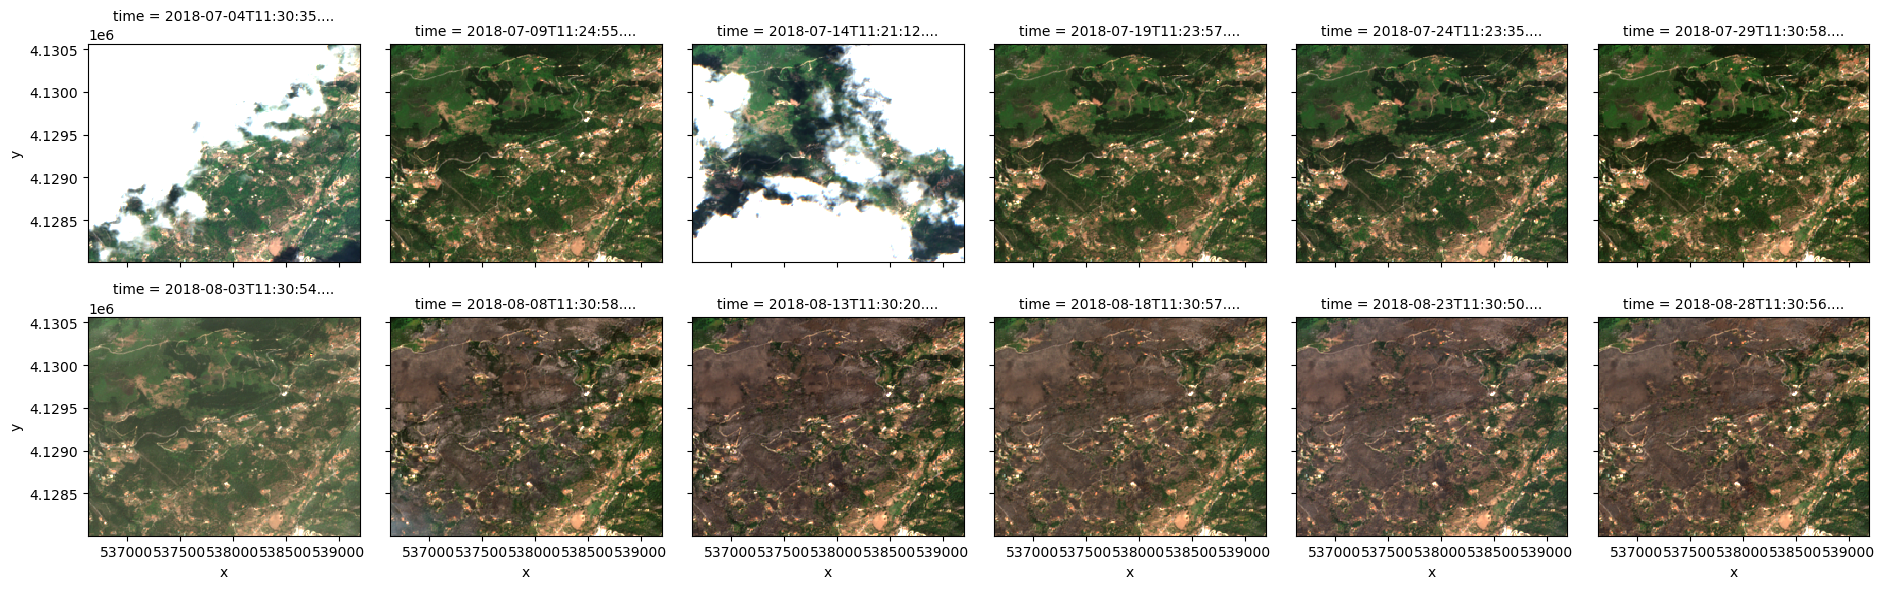

In [56]:
#lets have a look at the images

stack.sel(band=["red", "green", "blue"]).plot.imshow(
    row="time", rgb="band", vmin=0, vmax=2000, col_wrap=6
)

In [57]:
#Loading the model

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.set_default_device(device)

ckpt = 'clay-v1.5.ckpt'

try:
    model = ClayMAEModule.load_from_checkpoint(
        ckpt,
        model_size='large',
        metadata_path='configs/metadata.yaml',
        dolls=[16, 32, 64, 128, 256, 768, 1024],
        doll_weights=[1, 1, 1, 1, 1, 1, 1],
        mask_ration=0.0,
        shuffle=False,
    )
    print("✅ Model loaded successfully.")
except FileNotFoundError as fnf_error:
    print(f"❌ Checkpoint or metadata file not found: {fnf_error}")
except RuntimeError as rt_error:
    print(f"❌ Runtime error during model loading: {rt_error}")
except Exception as e:
    print(f"❌ Unexpected error: {e}")


✅ Model loaded successfully.


In [58]:
model.eval()

model = model.to(device)

In [164]:
stack.band

<xarray.DataArray 'band' (band: 4)> Size: 80B
array(['blue', 'green', 'red', 'nir'], dtype='<U5')
Coordinates: (12/19)
  * band                                     (band) <U5 80B 'blue' ... 'nir'
    mgrs:grid_square                         <U2 8B 'NB'
    constellation                            <U10 40B 'sentinel-2'
    instruments                              <U3 12B 'msi'
    mgrs:latitude_band                       <U1 4B 'S'
    s2:saturated_defective_pixel_percentage  int64 8B 0
    ...                                       ...
    title                                    (band) <U20 320B 'Blue (band 2) ...
    proj:transform                           object 8B {0, 4200000, 10, 49998...
    common_name                              (band) <U5 80B 'blue' ... 'nir'
    center_wavelength                        (band) float64 32B 0.49 ... 0.842
    full_width_half_max                      (band) float64 32B 0.098 ... 0.145
    epsg                                     int64 8B 32629

In [67]:
stack.time

<xarray.DataArray 'time' (time: 12)> Size: 96B
array(['2018-07-04T11:30:35.271000000', '2018-07-09T11:24:55.535000000',
       '2018-07-14T11:21:12.461000000', '2018-07-19T11:23:57.810000000',
       '2018-07-24T11:23:35.774000000', '2018-07-29T11:30:58.949000000',
       '2018-08-03T11:30:54.537000000', '2018-08-08T11:30:58.042000000',
       '2018-08-13T11:30:20.451000000', '2018-08-18T11:30:57.426000000',
       '2018-08-23T11:30:50.574000000', '2018-08-28T11:30:56.771000000'],
      dtype='datetime64[ns]')
Coordinates: (12/46)
  * time                                     (time) datetime64[ns] 96B 2018-0...
    id                                       (time) <U24 1kB 'S2B_29SNB_20180...
    s2:high_proba_clouds_percentage          (time) float64 96B 45.89 ... 28.83
    updated                                  (time) <U24 1kB '2022-11-08T04:0...
    view:sun_azimuth                         (time) float64 96B 130.7 ... 148.6
    s2:thin_cirrus_percentage                (time) object 96B 0.0001 ... 0.0...
    ...                                       ...
    s2:datatake_type                         <U8 32B 'INS-NOBS'
    s2:processing_baseline                   (time) <U5 240B '02.08' ... '05.00'
    gsd                                      int64 8B 10
    proj:shape                               object 8B {10980}
    proj:transform                           object 8B {0, 4200000, 10, 49998...
    epsg                                     int64 8B 32629

In [123]:
for b in stack.band:
    print(b.values)

blue
green
red
nir


In [148]:
#prepare band metadata for passing it to the model
#converting lat/lon values and date of imagery into normalized values

#this model needs wavelenght of each band passed to it and normalization parameters for each band
# using sentinel-2 data -> metadata file of model to extract the above values

#extract mean, std & wavelenght from metadata

platform = 'sentinel-2-l2a'
metadata = Box(yaml.safe_load(open('configs/metadata.yaml')))
mean =[]
std = []
waves =[]

#using band names to get coorect values in correct order

for band in stack.band:
    mean.append(metadata[platform].bands.mean[str(band.values)])
    std.append(metadata[platform].bands.std[str(band.values)])
    waves.append(metadata[platform].bands.wavelength[str(band.values)])


In [149]:
#preparing the normalization transform function using the mean and std values

transform = v2.Compose(
    [
        v2.Normalize(mean=mean,std=std),
    ]
)

In [153]:
#converting the band pixel into format of the model

#converting info in the stack of imagery and convert to format of the model requirement 
#including converting lat/lon & dates into normalized values

#prep datetimes embedding using a normalization function of the model
def normalize_timestamp(date):
    week = date.isocalendar().week*2*np.pi/52
    hour = date.hour*2*np.pi/24
    
    return (math.sin(week), math.cos(week), math.sin(hour), math.cos(hour))

datetimes = stack.time.values.astype('datetime64[s]').tolist()
times = [normalize_timestamp(dat) for dat in datetimes]
#week_norm = [dat[0] for dat in times]
#hour_norm = [dat[1] for dat in times]

In [154]:
datetimes

[datetime.datetime(2018, 7, 4, 11, 30, 35),
 datetime.datetime(2018, 7, 9, 11, 24, 55),
 datetime.datetime(2018, 7, 14, 11, 21, 12),
 datetime.datetime(2018, 7, 19, 11, 23, 57),
 datetime.datetime(2018, 7, 24, 11, 23, 35),
 datetime.datetime(2018, 7, 29, 11, 30, 58),
 datetime.datetime(2018, 8, 3, 11, 30, 54),
 datetime.datetime(2018, 8, 8, 11, 30, 58),
 datetime.datetime(2018, 8, 13, 11, 30, 20),
 datetime.datetime(2018, 8, 18, 11, 30, 57),
 datetime.datetime(2018, 8, 23, 11, 30, 50),
 datetime.datetime(2018, 8, 28, 11, 30, 56)]

In [158]:
len(times)

12

In [159]:
ws, wc, hs, hc = [], [], [], []

for dat in datetimes:
    w_s, w_c, h_s, h_c = normalize_timestamp(dat)
    ws.append(w_s)
    wc.append(w_c)
    hs.append(h_s)
    hc.append(h_c)
    
time_tensor = torch.tensor(
    np.column_stack((ws,wc,hs,hc)),
    dtype=torch.float32,
    device=device
)

In [160]:
#Prep lat/lon embedding 
def normalize_latlon(lat,lon):
    lat1 = lat * np.pi / 180
    lon1 = lon * np.pi / 180

    return (math.sin(lat1), math.cos(lat1), math.sin(lon1), math.cos(lon1))

#latlons = [normalize_latlon(lat,lon)] * len(times)
#lat_norm = [dat[0] for dat in latlons]
#lon_norm = [dat[1] for dat in latlons]

In [166]:
stack

<xarray.DataArray 'stackstac-2592887a89cb804ce20441257ae025ba' (time: 12,
                                                                band: 4,
                                                                y: 256, x: 256)> Size: 25MB
array([[[[ 9136.,  9232.,  9544., ...,  1258.,  1120.,   930.],
         [ 9616.,  9768.,  9840., ...,  1230.,  1208.,  1030.],
         [ 9992., 10008., 10000., ...,  1418.,  1336.,  1242.],
         ...,
         [  811.,   655.,   688., ...,   385.,   362.,   461.],
         [  798.,   675.,   727., ...,   394.,   415.,   402.],
         [  888.,   673.,   642., ...,   403.,   454.,   393.]],

        [[ 8656.,  8656.,  8864., ...,  1500.,  1428.,  1220.],
         [ 9016.,  9160.,  9224., ...,  1546.,  1522.,  1360.],
         [ 9248.,  9328.,  9384., ...,  1620.,  1542.,  1482.],
         ...,
         [ 1010.,   831.,   853., ...,   277.,   276.,   336.],
         [ 1016.,   930.,   927., ...,   276.,   317.,   293.],
         [ 1112.,   885.,   827., ...,   299.,   369.,   293.]],

        [[ 8416.,  8416.,  8640., ...,  1598.,  1466.,  1138.],
         [ 8744.,  8880.,  8928., ...,  1498.,  1522.,  1284.],
         [ 8952.,  8944.,  8960., ...,  1542.,  1478.,  1448.],
         ...,
...
         [  652.,   640.,   638., ...,   590.,   821.,  1008.],
         [  622.,   676.,   630., ...,   606.,  1092.,   726.],
         [  864.,   786.,   569., ...,   766.,  1068.,   630.]],

        [[  201.,   213.,   195., ...,  1138.,  1058.,   749.],
         [  196.,   198.,   169., ...,   861.,   784.,   768.],
         [  216.,   178.,   191., ...,   870.,   806.,   820.],
         ...,
         [  857.,   838.,   846., ...,   622.,   800.,  1332.],
         [  922.,   848.,   771., ...,   786.,  1046.,   912.],
         [ 1118.,  1010.,   735., ...,   755.,   977.,   686.]],

        [[ 3264.,  3352.,  3304., ...,  3160.,  3296.,  3376.],
         [ 3356.,  3300.,  3212., ...,  3188.,  3272.,  3064.],
         [ 3288.,  3372.,  3344., ...,  3136.,  3200.,  2932.],
         ...,
         [ 1320.,  1468.,  1298., ...,  2492.,  2556.,  3018.],
         [ 1630.,  1694.,  1250., ...,  2318.,  2684.,  2894.],
         [ 2190.,  2072.,  1288., ...,  2544.,  2942.,  2928.]]]],
      shape=(12, 4, 256, 256))
Coordinates: (12/53)
  * time                                     (time) datetime64[ns] 96B 2018-0...
    id                                       (time) <U24 1kB 'S2B_29SNB_20180...
  * band                                     (band) <U5 80B 'blue' ... 'nir'
  * x                                        (x) float64 2kB 5.366e+05 ... 5....
  * y                                        (y) float64 2kB 4.131e+06 ... 4....
    s2:high_proba_clouds_percentage          (time) float64 96B 45.89 ... 28.83
    ...                                       ...
    title                                    (band) <U20 320B 'Blue (band 2) ...
    proj:transform                           object 8B {0, 4200000, 10, 49998...
    common_name                              (band) <U5 80B 'blue' ... 'nir'
    center_wavelength                        (band) float64 32B 0.49 ... 0.842
    full_width_half_max                      (band) float64 32B 0.098 ... 0.145
    epsg                                     int64 8B 32629
Attributes:
    spec:        RasterSpec(epsg=32629, bounds=(536640.79691545, 4128000.7407...
    crs:         epsg:32629
    transform:   | 10.00, 0.00, 536640.80|\n| 0.00,-10.00, 4130560.74|\n| 0.0...
    resolution:  10

In [167]:
# Extract from stack metadata
lat = stack.y.mean().item()
lon = stack.x.mean().item()

# Normalize once
l_sin, l_cos, lo_sin, lo_cos = normalize_latlon(lat, lon)

# Repeat for each image
latlon_tensor = torch.tensor(
    [[l_sin, l_cos, lo_sin, lo_cos]] * len(stack.time),
    dtype=torch.float32,
    device=device,
)


In [168]:
#Normalize pizels

pixels = torch.from_numpy(stack.data.astype(np.float32))
pixels = transform(pixels)

In [ ]:
#Combine the metadata and transformed pixels


#combine all into dictionary

#prepare additional info

#datacube = {
#    'platform': platform,
#    'time': torch.tensor(
#        np.column_stack((week_norm,hour_norm)),
#        dtype=torch.float32,
#        device=device,
#    ),
#    'latlon': torch.tensor(
#        np.column_stack((lat_norm,lon_norm)),
#        dtype=torch.float32,
#        device=device,
#    ),
#    'pixels': pixels.to(device),
#    'gsd': torch.tensor(stack.gsd.values,
#                        device=device
#    ),
#    'waves':torch.tensor(waves,
#                         device=device
#    ),
#    }

In [170]:
datacube = {
    'platform': platform,
    'time' : time_tensor,
    'latlon' : latlon_tensor,
    'pixels' : pixels.to(device),
    'gsd' : torch.tensor(stack.gsd.values, device=device),
    'waves' : torch.tensor(waves, device=device),
}

In [171]:
for key in ['pixels', 'time', 'latlon']:
    print(f"{key} shape: {datacube[key].shape}")


pixels shape: torch.Size([12, 4, 256, 256])
time shape: torch.Size([12, 4])
latlon shape: torch.Size([12, 4])


In [172]:
#Run the model

#pass the datacube prepared above to the model to create embeddings.
#this will create 1 embedding vector for each image we downloaded


with torch.no_grad():
    unmsk_patch, unmsk_idx, msk_idx, msk_matrix = model.model.encoder(datacube)


In [175]:
# The first embedding is the class token, which is the
# overall single embedding. We extract that for PCA below.
embeddings = unmsk_patch[:, 0, :].cpu().numpy()

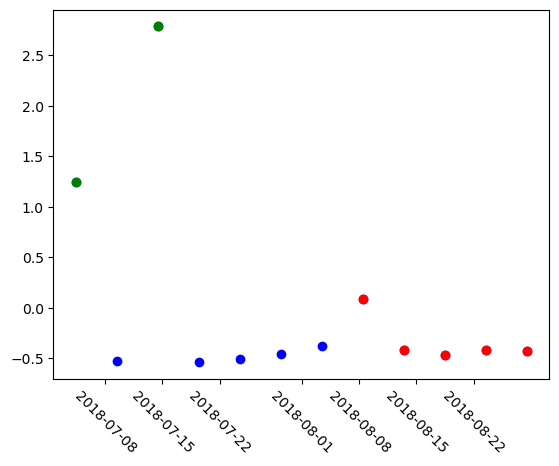

In [177]:
#analkyse the embeddings

#run pca
pca = decomposition.PCA(n_components=1)
pca_result = pca.fit_transform(embeddings)

plt.xticks(rotation=-45)

#plot all points in blue first
plt.scatter(stack.time, pca_result, color = 'blue')

#re-plot cloudy images in green
plt.scatter(stack.time[0], pca_result[0], color='green')
plt.scatter(stack.time[2], pca_result[2],color='green')

#color all images after fire in red
plt.scatter(stack.time[-5:], pca_result[-5:], color ='red')

In [178]:
# Label the images we downloaded
# 0 = Cloud
# 1 = Forest
# 2 = Fire
labels = np.array([0, 1, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2])

# Split into fit and test manually, ensuring we have all 3 classes in both sets
fit = [0, 1, 3, 4, 7, 8, 9]
test = [2, 5, 6, 10, 11]

# Train a Support Vector Machine model
clf = svm.SVC()
clf.fit(embeddings[fit] + 100, labels[fit])

# Predict classes on test set
prediction = clf.predict(embeddings[test] + 100)

# Perfect match for SVM
match = np.sum(labels[test] == prediction)
print(f"Matched {match} out of {len(test)} correctly")

Matched 4 out of 5 correctly


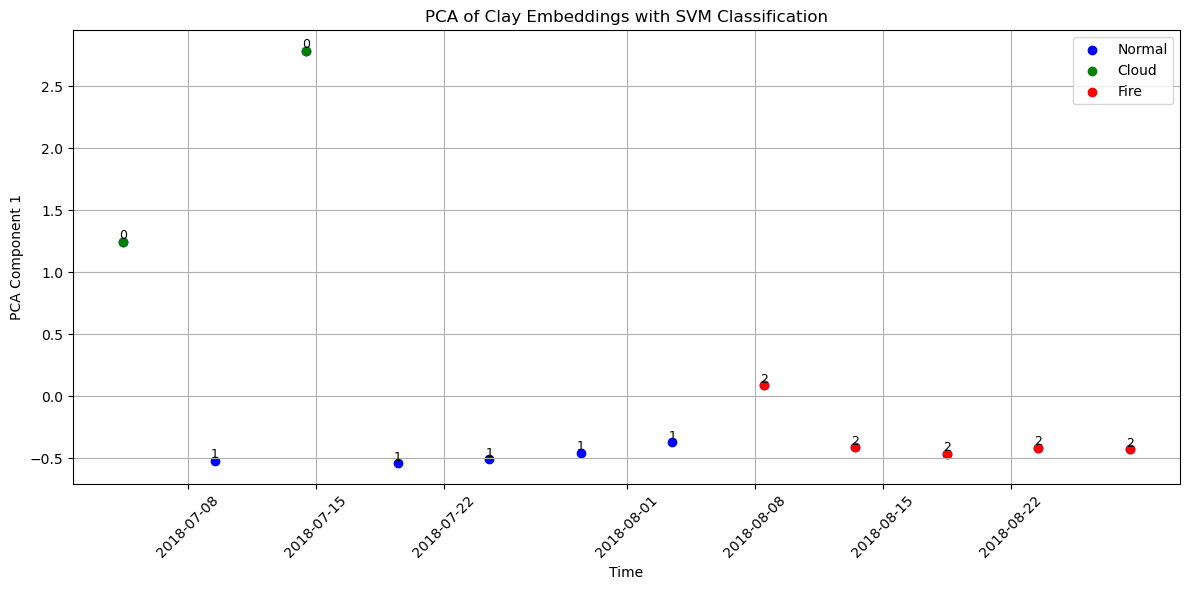

In [179]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Convert PCA result to 1D
pca_result = pca_result.squeeze()

# Create figure
fig, ax = plt.subplots(figsize=(12, 6))

# Format x-axis as dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)

# Plot all points in blue
ax.scatter(stack.time.values, pca_result, color='blue', label='Normal')

# Highlight cloudy images in green
ax.scatter(stack.time.values[0], pca_result[0], color='green', label='Cloud')
ax.scatter(stack.time.values[2], pca_result[2], color='green')

# Highlight fire images in red
ax.scatter(stack.time.values[-5:], pca_result[-5:], color='red', label='Fire')

# Annotate each point with its label
for i, label in enumerate(labels):
    ax.text(stack.time.values[i], pca_result[i] + 0.02, str(label), fontsize=9, ha='center')

# Optional: overlay thumbnails if available
def plot_thumbnail(ax, image_array, xy, zoom=0.2):
    imagebox = OffsetImage(image_array, zoom=zoom)
    ab = AnnotationBbox(imagebox, xy, frameon=False)
    ax.add_artist(ab)

# Example: overlay thumbnails for test set
# Assuming you have thumbnails as numpy arrays: thumbnails[i] = [H, W, 3]
# for i in test:
#     plot_thumbnail(ax, thumbnails[i], (stack.time.values[i], pca_result[i]))

# Final touches
plt.title("PCA of Clay Embeddings with SVM Classification")
plt.xlabel("Time")
plt.ylabel("PCA Component 1")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
